# Рекомендации по выполнению проекта

1. Проведите первичную обработку данных. Так как данных много, стоит написать функции, которые можно применять к столбцам определённого типа.
2. Посмотрите на распределение признака для числовых переменных, устраните выбросы.
3. Оцените количество уникальных значений для номинативных переменных.
   По необходимости преобразуйте данные
4. Проведите корреляционный анализ количественных переменных
   Отберите не коррелирующие переменные.
5. Проанализируйте номинативные переменные и устраните те, которые не влияют на предсказываемую величину (в нашем случае — на переменную score).
6. Не забудьте сформулировать выводы относительно качества данных и тех переменных, которые вы будете использовать в дальнейшем построении модели.

In [2]:
import pandas as pd
import math
import matplotlib.pyplot as plt
import seaborn as sns
import statistics
import collections 
import warnings; warnings.simplefilter('ignore')


from collections import Counter
from itertools import combinations
from scipy.stats import ttest_ind

stud_math = pd.read_csv('stud_math.csv')

## Первичная обработка данных

In [8]:
#смотрим типы столбцов
stud_math.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 29 columns):
school         395 non-null object
sex            395 non-null object
age            395 non-null int64
address        378 non-null object
famsize        368 non-null object
Pstatus        350 non-null object
Medu           395 non-null float64
Fedu           395 non-null float64
Mjob           376 non-null object
Fjob           359 non-null object
reason         378 non-null object
guardian       364 non-null object
traveltime     395 non-null float64
studytime      395 non-null float64
schoolsup      386 non-null object
famsup         356 non-null object
paid           355 non-null object
activities     381 non-null object
nursery        379 non-null object
studytime_g    395 non-null float64
higher         375 non-null object
internet       361 non-null object
romantic       364 non-null object
famrel         395 non-null float64
freetime       395 non-null float64
goout         

In [7]:
#для начала анализируем числовые показатели датасета
stud_math.describe()
#видим "выбросы" в столбце absences, Fedu, под вопросом age 

,age,Medu,Fedu,traveltime,studytime,studytime_g,famrel,freetime,goout,health,absences,score
count,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000
mean,16.696203,2.751899,2.577215,1.407595,2.037975,-6.113924,3.946835,3.225316,3.103797,3.549367,7.179747,52.303797
std,1.276043,1.094154,2.164782,0.678490,0.834580,2.503740,0.872425,0.980711,1.104610,1.372118,23.111967,22.746314
min,15.000000,0.000000,0.000000,1.000000,1.000000,-12.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000
25%,16.000000,2.000000,2.000000,1.000000,1.000000,-6.000000,4.000000,3.000000,2.000000,3.000000,0.000000,40.000000
50%,17.000000,3.000000,2.000000,1.000000,2.000000,-6.000000,4.000000,3.000000,3.000000,4.000000,4.000000,55.000000
75%,18.000000,4.000000,3.000000,2.000000,2.000000,-3.000000,4.500000,4.000000,4.000000,5.000000,8.000000,70.000000
max,22.000000,4.000000,40.000000,4.000000,4.000000,-3.000000,5.000000,5.000000,5.000000,5.000000,385.000000,100.000000


In [6]:
#считаем количество пропусков по столбцам
stud_math.isna().sum()

school          0
sex             0
age             0
address        17
famsize        27
Pstatus        45
Medu            0
Fedu            0
Mjob           19
Fjob           36
reason         17
guardian       31
traveltime      0
studytime       0
schoolsup       9
famsup         39
paid           40
activities     14
nursery        16
studytime_g     0
higher         20
internet       34
romantic       31
famrel          0
freetime        0
goout           0
health          0
absences        0
score           0
dtype: int64

In [20]:
#для удобства переименовываем столбец 'studytime, granular'
stud_math.rename(columns={'studytime, granular': 'studytime_g'},inplace=True)

In [21]:
# убираем отрицательные значения в столбце famrel, так как по условиям задачи данные столбцы содержат положительные величины 
stud_math.famrel = stud_math.famrel.apply(lambda x: math.fabs(x))

In [22]:
#удаляем столбец failures в виду большого количества нулей
#stud_math.drop(['failures'], inplace = True, axis = 1)

#Для удобства формируем новый датасет из столбцов с количественными и категориальными признаками для удаения выбросов

stud_math_numeric = stud_math[['age','absences','Fedu','score']]

#Для удобства формируем новый датасет из столбцов с  категориальными признаками для построения графики
stud_math_categor = stud_math[['school','Medu','Fedu','sex', 'traveltime','address',
                               'famsize','Pstatus','Mjob','Fjob','reason', 'guardian', 
                               'studytime','schoolsup','famsup','paid','activities','nursery',
                               'higher','internet','romantic','famrel','freetime','goout','health']]


In [23]:
#для категориальных не числовых признаков описываем функции меняющие Nan/nan на None 
def add_none_up(x):
    x = x.astype(str).apply(lambda y: 'None' if pd.isnull(y) else 'None' if y == 'NaN' 
                      else y if '(' not in y else x[:y.find('(')].strip())
    return x

def add_none_low(x):
    x = x.astype(str).apply(lambda y: 'None' if pd.isnull(y) else 'None' if y == 'nan' 
                      else y if '(' not in y else x[:y.find('(')].strip())
    return x

#поизводим замену Nan|nan Ha None
stud_math_categor = stud_math_categor.apply(lambda x: add_none_up(x))
stud_math_categor = stud_math_categor.apply(lambda x: add_none_low(x))

In [24]:
#анализируем номиативные столбцы для принятия решений по замене пропусков
#посмотрим на нулевые значения и пропуски по столбцам
#заменим пропуски для числовых столбцов на медиану 
stud_math = stud_math.fillna(stud_math.median())
#для номиативных переменных пустые значения возможно менять с учетом корреляций с другими столбцами, например Pststus c Traveltime и Mjob

##Устраняем выбросы

In [25]:
#Описываем функцию по устранению выбросов
def cut_emissions(x):
    median = x.median()
    IQR = x.quantile(0.75) - x.quantile(0.25)
    perc25 = x.quantile(0.25)
    perc75 = x.quantile(0.75)
    x = x.loc[x.between(perc25 - 1.5*IQR, perc75 + 1.5*IQR)]
    return x

#применяем функцию по удлаению выбросов последовательно к каждому числовому столбцу датафрейма,
#предварительно строим гистограммы по каждому столбцу, что бы избежать удаления информативных данных
#пример построения гистограммы приведен для одного столба(что бы не нагружать код)

#пример построения гистограммы для столбца age, для переменной score анализ показал отсутствие выбросов 
#median = stud_math.age.median()
#IQR = stud_math.age.quantile(0.75) - stud_math.age.quantile(0.25)
#perc25 = stud_math.age.quantile(0.25)
#perc75 = stud_math.age.quantile(0.75)

#print('25-й перцентиль: {},'.format(perc25), '75-й перцентиль: {},'.format(perc75)
#      , "IQR: {}, ".format(IQR),"Границы выбросов: [{f}, {l}].".format(f=perc25 - 1.5*IQR, l=perc75 + 1.5*IQR))
#stud_math.age.loc[stud_math.age.between(perc25 - 1.5*IQR, perc75 + 1.5*IQR)].hist(bins = 16, range = (0, 25), label = 'IQR')

#stud_math.age.loc[stud_math.age <= 100].hist(alpha = 0.5, bins = 16, range = (0, 25),label = 'Здравый смысл')
#plt.legend();

# применяем функцию по устранению выбросов к ранее созданому датафрейму
stud_math_numeric = stud_math_numeric.apply(lambda x: cut_emissions(x)) 

##Оценим количество уникальных значений для номинативных переменных.

Text(0.5, 1.0, 'ЧР признака health ')

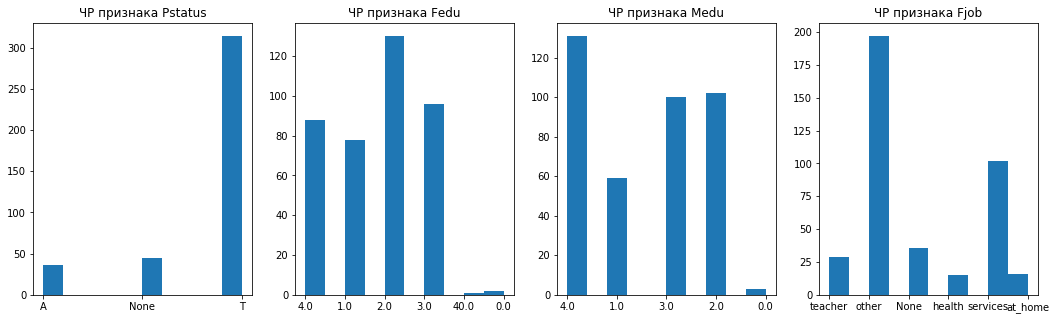

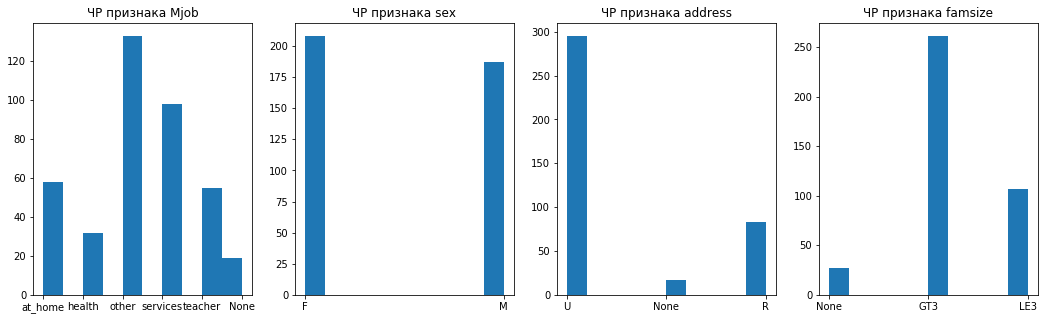

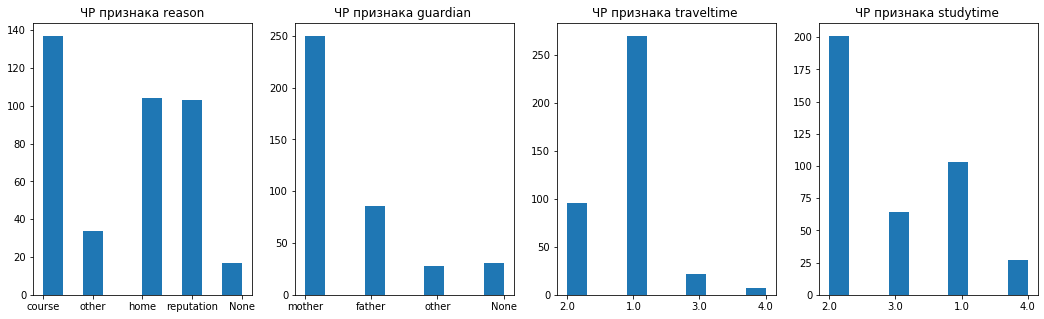

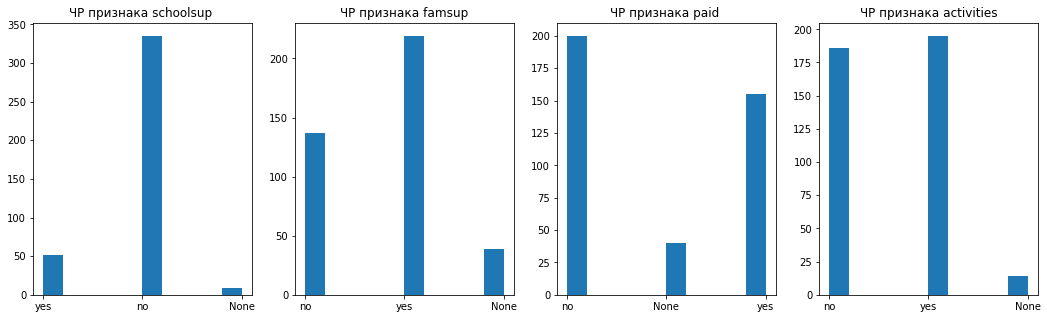

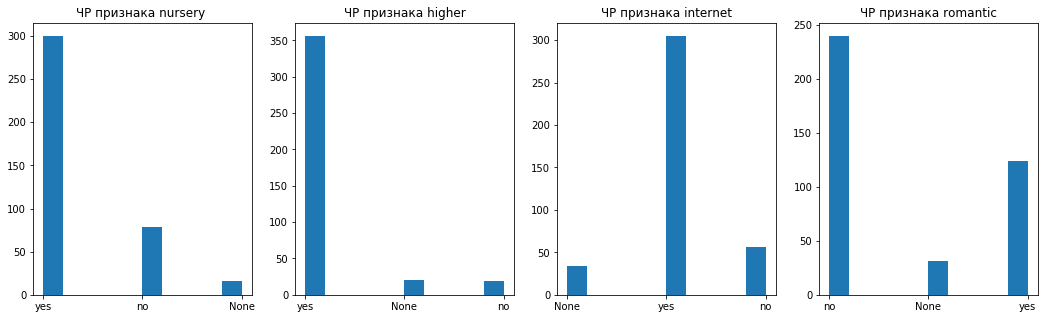

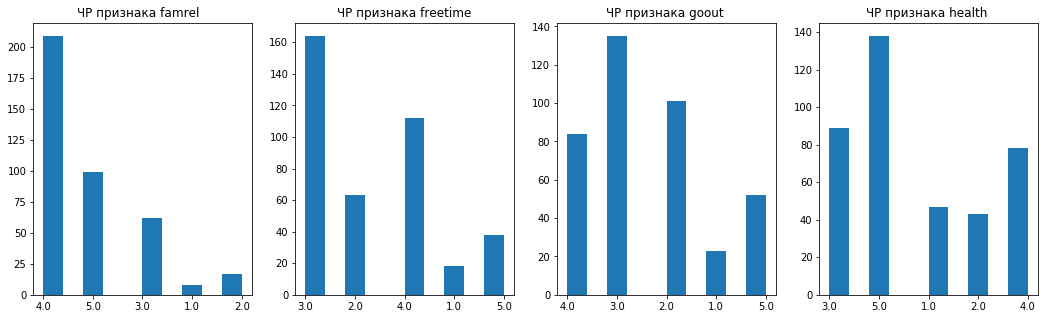

In [26]:
# построим соответствующие гистограммы 
# по результатам просмотра распределений опеределим данные со значимыми(разница между значениями более чем 2 раза) 
# разрывами по значениям:
# pstatus fjob adress famsize guardian traveltime studytime schoolsup nursery higner internet romantic
# возможно при построении boxplot имеет смысл использовать указанные столбцы в качестве признака 
# дополнительного распределения 
fig, axes = plt.subplots(1,4, figsize = (18,5))
axes[0].hist(stud_math_categor['Pstatus'])
axes[0].set_title('ЧР признака Pstatus') 

axes[1].hist(stud_math_categor['Fedu'])
axes[1].set_title('ЧР признака Fedu') 

axes[2].hist(stud_math_categor['Medu'])
axes[2].set_title('ЧР признака Medu') 

axes[3].hist(stud_math_categor['Fjob'])
axes[3].set_title('ЧР признака Fjob') 

fig1, axes1 = plt.subplots(1,4, figsize = (18,5))
axes1[0].hist(stud_math_categor['Mjob'])
axes1[0].set_title('ЧР признака Mjob') 

axes1[1].hist(stud_math_categor['sex'])
axes1[1].set_title('ЧР признака sex') 

axes1[2].hist(stud_math_categor['address'])
axes1[2].set_title('ЧР признака address') 

axes1[3].hist(stud_math_categor['famsize'])
axes1[3].set_title('ЧР признака famsize') 

fig2, axes2= plt.subplots(1,4, figsize = (18,5))
axes2[0].hist(stud_math_categor['reason'])
axes2[0].set_title('ЧР признака reason') 

axes2[1].hist(stud_math_categor['guardian'])
axes2[1].set_title('ЧР признака guardian ') 

axes2[2].hist(stud_math_categor['traveltime'])
axes2[2].set_title('ЧР признака traveltime ') 

axes2[3].hist(stud_math_categor['studytime'])
axes2[3].set_title('ЧР признака studytime ')

fig3, axes3= plt.subplots(1,4, figsize = (18,5))
axes3[0].hist(stud_math_categor['schoolsup'])
axes3[0].set_title('ЧР признака schoolsup ') 

axes3[1].hist(stud_math_categor['famsup'])
axes3[1].set_title('ЧР признака famsup') 

axes3[2].hist(stud_math_categor['paid'])
axes3[2].set_title('ЧР признака paid ') 

axes3[3].hist(stud_math_categor['activities'])
axes3[3].set_title('ЧР признака activities')

fig4, axes4= plt.subplots(1,4, figsize = (18,5))
axes4[0].hist(stud_math_categor['nursery'])
axes4[0].set_title('ЧР признака nursery ') 

axes4[1].hist(stud_math_categor['higher'])
axes4[1].set_title('ЧР признака higher') 

axes4[2].hist(stud_math_categor['internet'])
axes4[2].set_title('ЧР признака internet') 

axes4[3].hist(stud_math_categor['romantic'])
axes4[3].set_title('ЧР признака romantic')

fig5, axes5= plt.subplots(1,4, figsize = (18,5))
axes5[0].hist(stud_math_categor['famrel'])
axes5[0].set_title('ЧР признака famrel  ') 

axes5[1].hist(stud_math_categor['freetime'])
axes5[1].set_title('ЧР признака freetime') 

axes5[2].hist(stud_math_categor['goout'])
axes5[2].set_title('ЧР признака goout ') 

axes5[3].hist(stud_math_categor['health'])
axes5[3].set_title('ЧР признака health ')

##Коррелиационный анализ 

,age,absences,Fedu,score
age,1.000000,0.126168,-0.153355,-0.148790
absences,0.126168,1.000000,-0.025058,0.078062
Fedu,-0.153355,-0.025058,1.000000,0.130516
score,-0.148790,0.078062,0.130516,1.000000


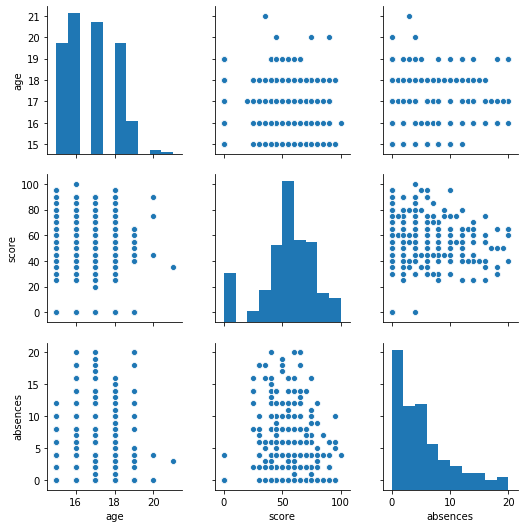

In [27]:
#Проведем аналих для числовых переменных
#строим графики зависимости переменных 
sns.pairplot(stud_math_numeric, vars=['age','score','absences'])
#строим матрицу корелляций
display(stud_math_numeric.corr())
# полученные данные повзоялют предположить, что между числовыми 
#признаками корреляция отсутствует(есть очень слабая корреляция между score и absences, что кажется не логичным корреляция могла бы быть и выше)
# с age наблюдается не значительная отрицательная корреляция, данный столбец для анализа можно не использовать


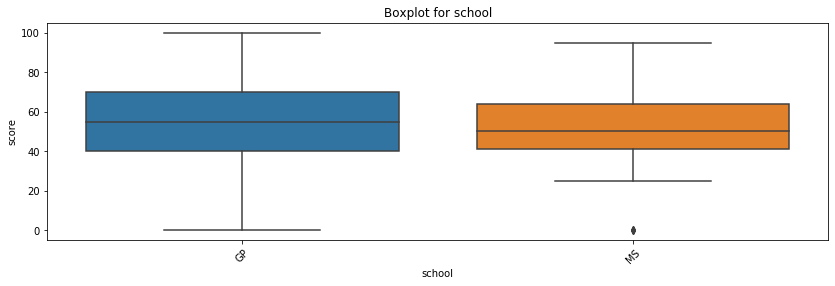

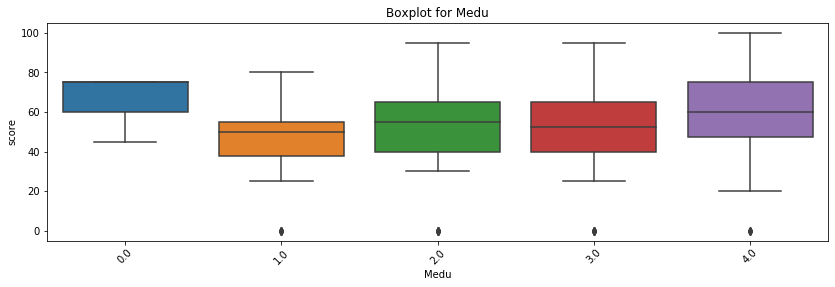

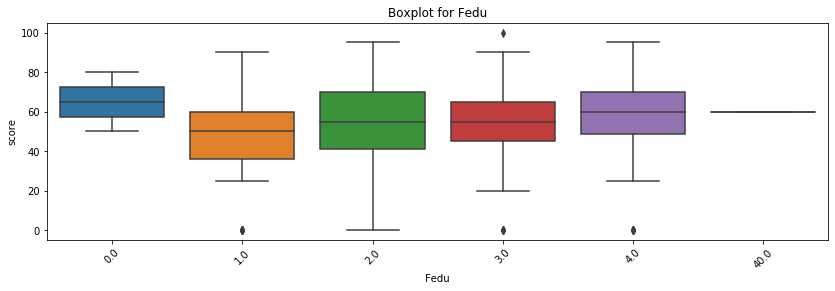

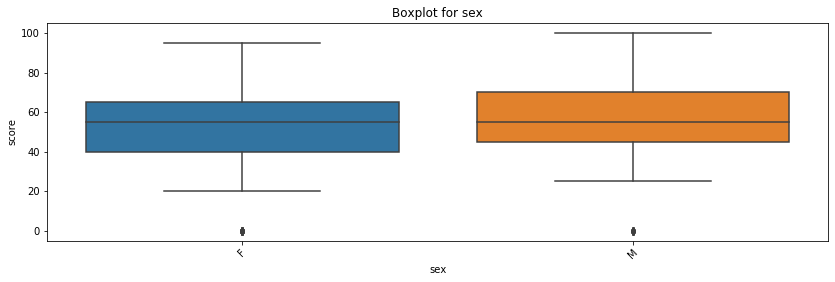

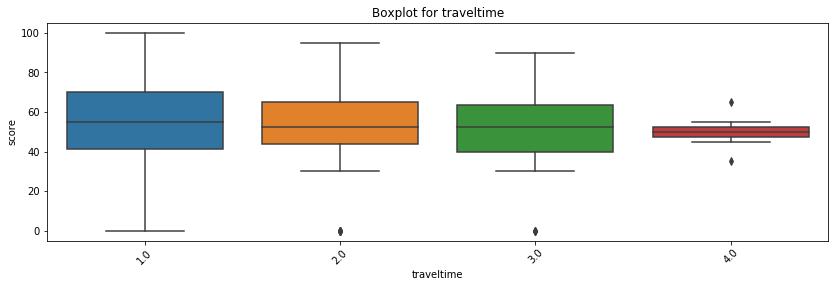

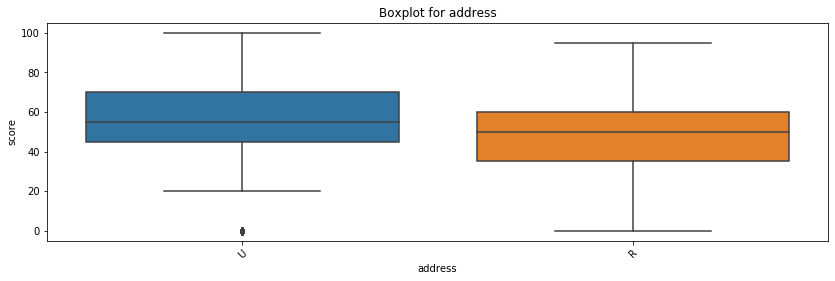

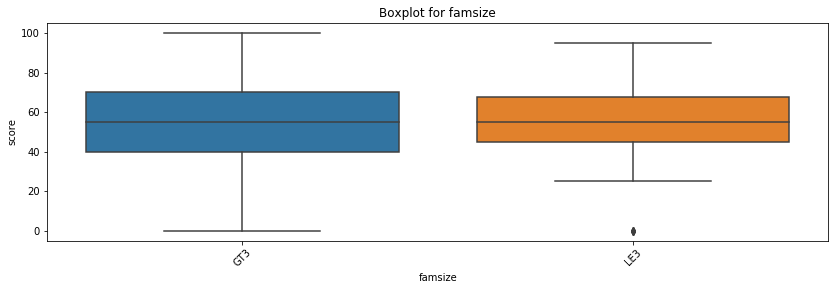

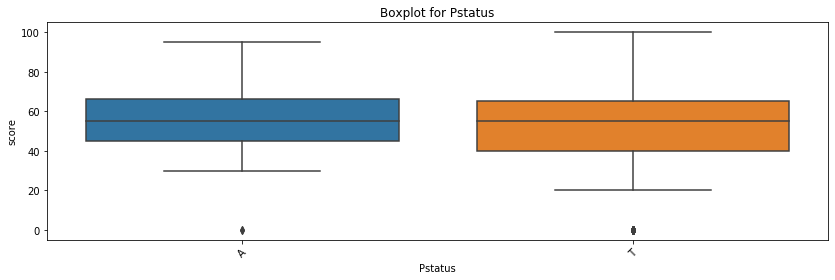

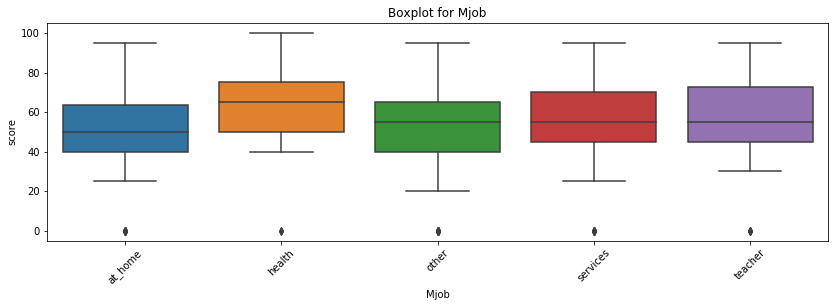

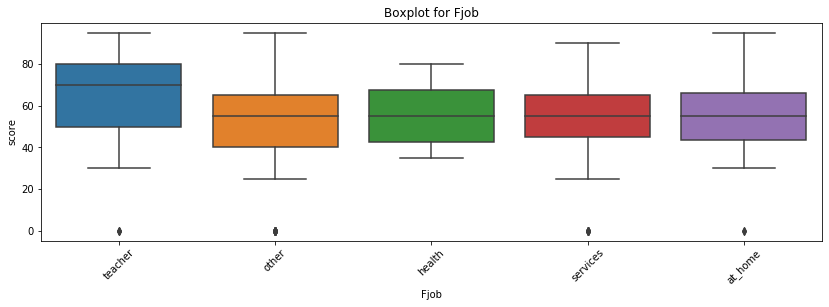

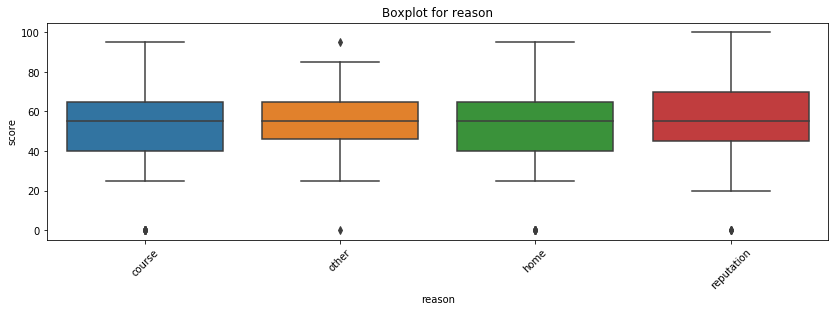

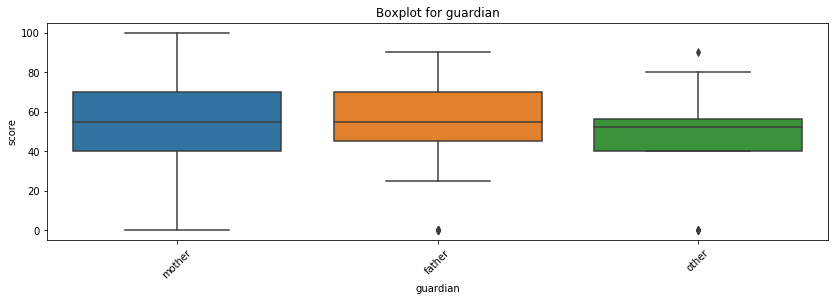

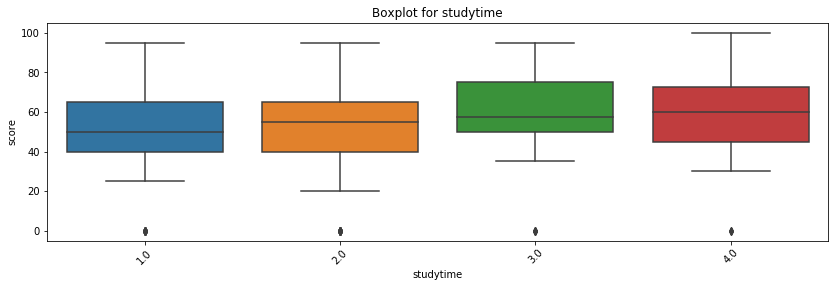

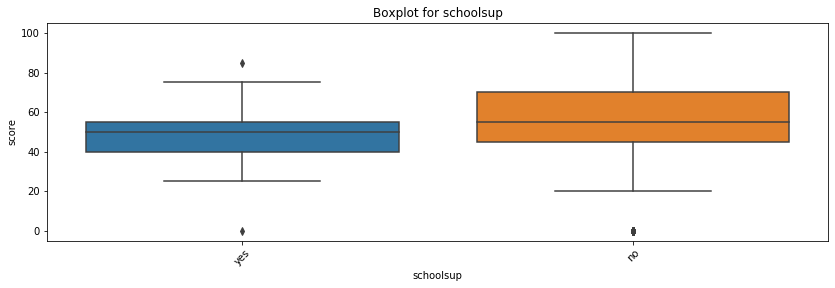

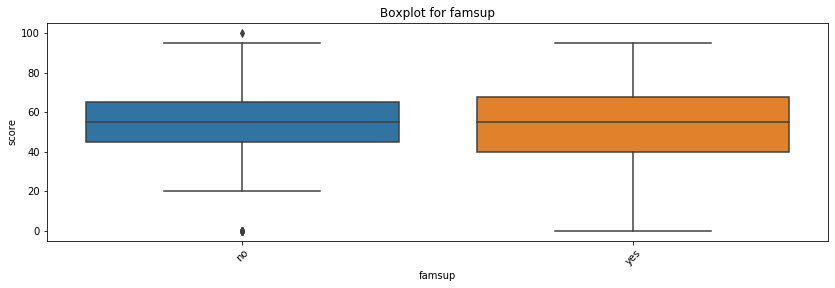

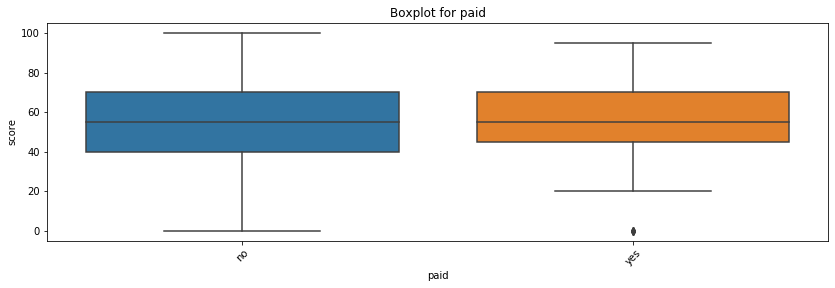

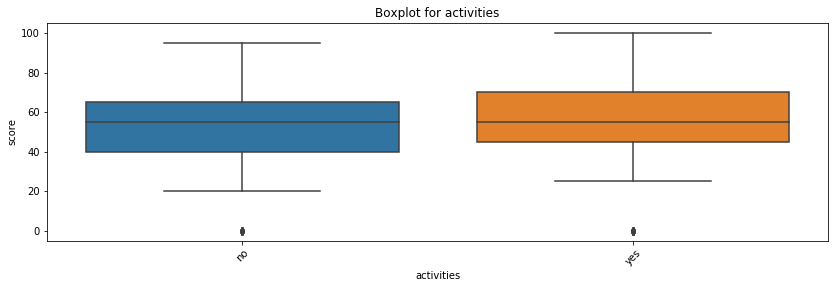

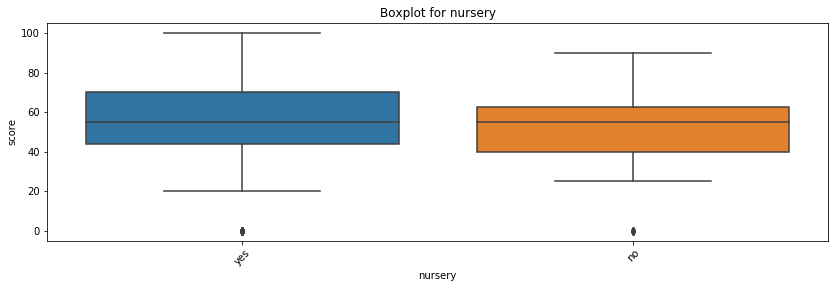

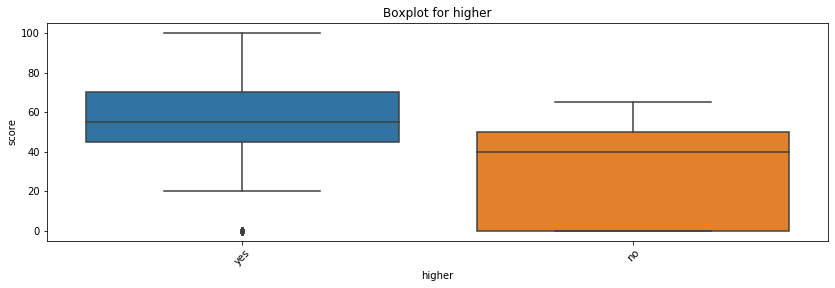

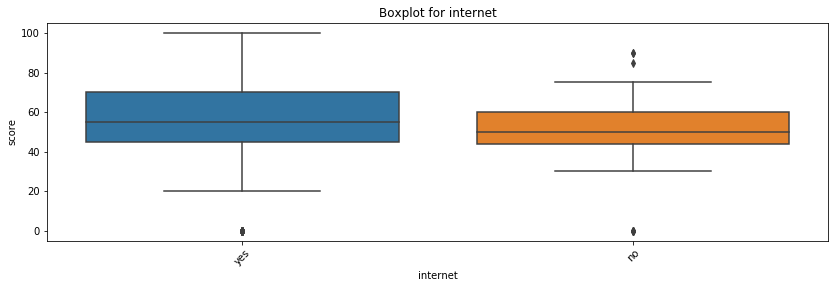

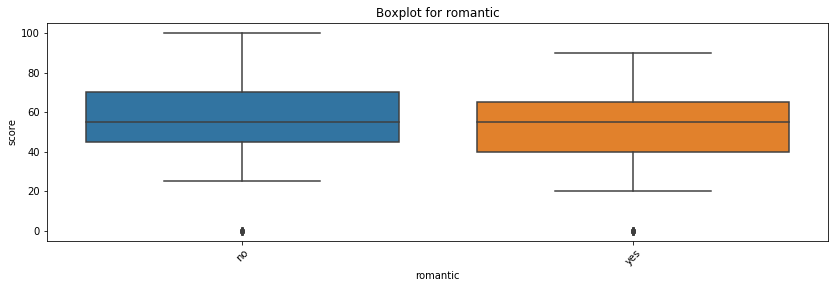

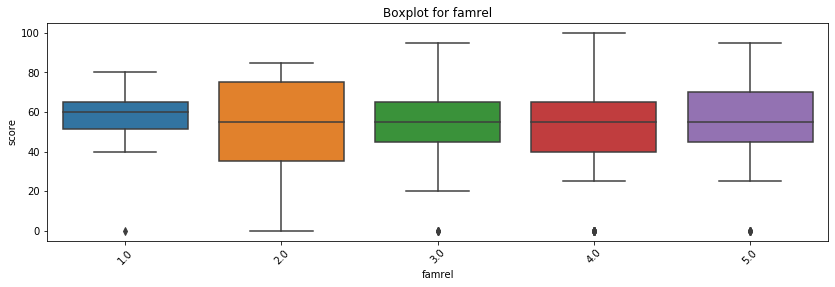

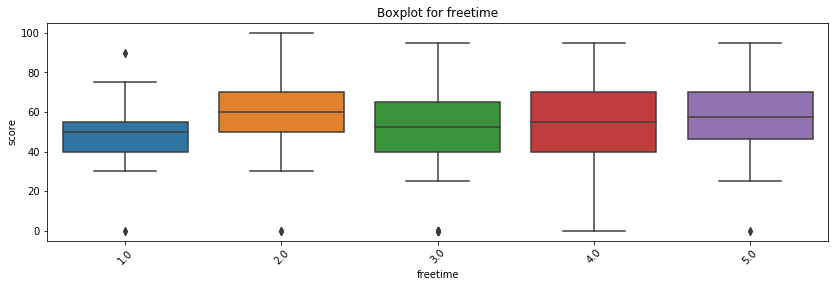

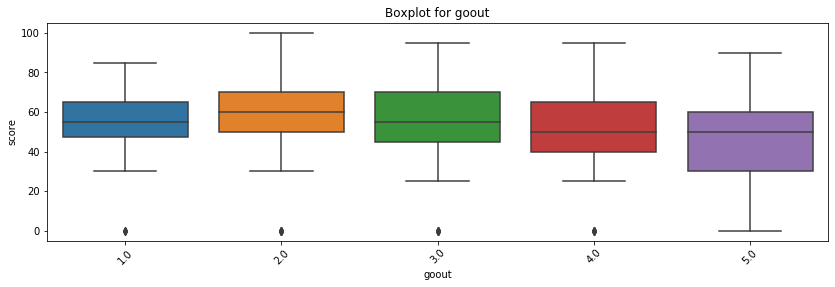

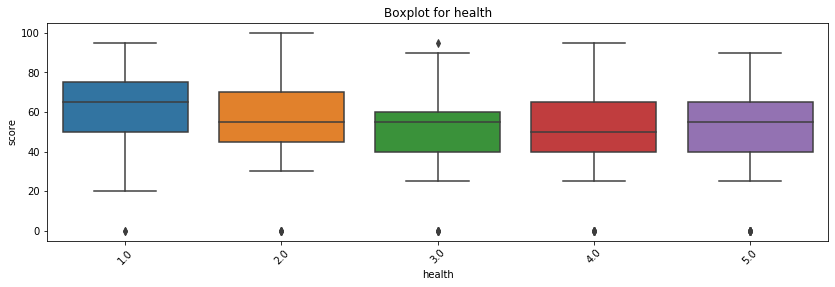

In [28]:
#Проанализируем номинативные переменные и устраним те, которые не влияют на предсказываемую величину
# перейдем к графическому анализу номиативных переменных с использованием boxplot
# опишем функцию отображения 
def get_boxplot(column):
    fig, ax = plt.subplots(figsize = (14, 4))
    sns.boxplot(x=column, y='score', 
                data=stud_math.loc[stud_math.loc[:, column].isin(stud_math.loc[:, column])],#,hue ='romantic',
               ax=ax)
    plt.xticks(rotation=45)
    ax.set_title('Boxplot for ' + column)
    plt.show()
#отобразим данные
for col in ['school','Medu','Fedu','sex', 'traveltime','address','famsize','Pstatus','Mjob','Fjob','reason', 'guardian', 'studytime','schoolsup','famsup','paid','activities','nursery','higher','internet','romantic','famrel','freetime','goout','health']:
    get_boxplot(col)

#визуальный анализ позволяет нам сделать вывод о возможной корреляции номинативных переменных со score 

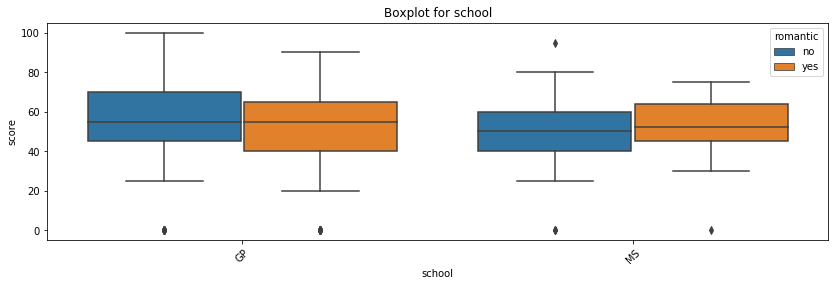

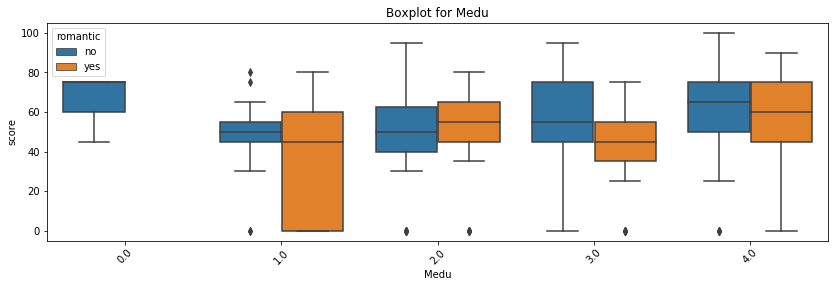

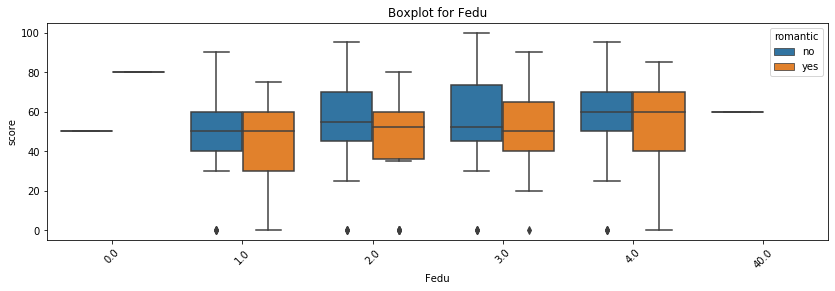

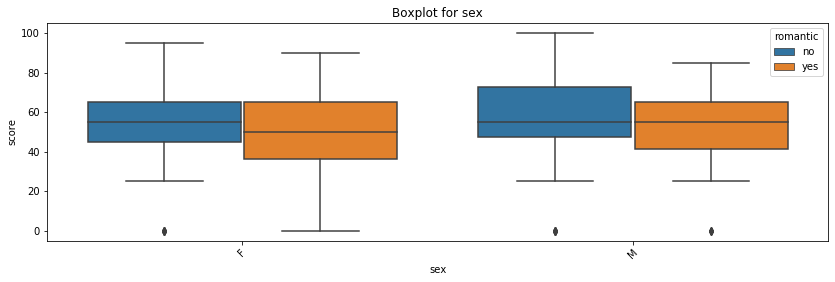

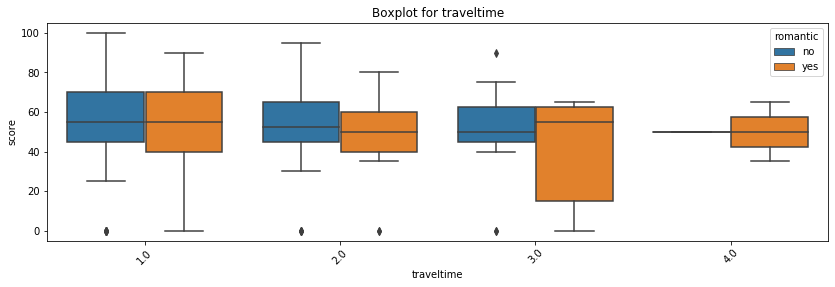

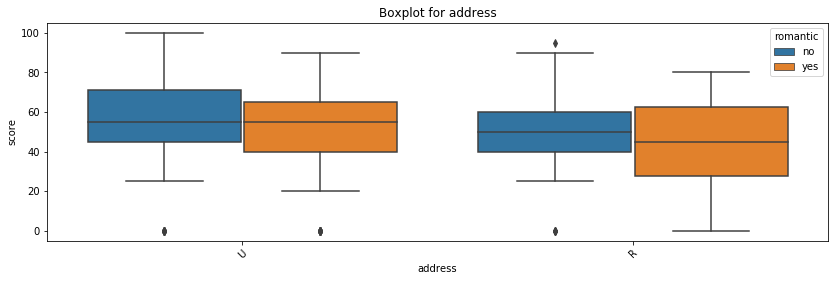

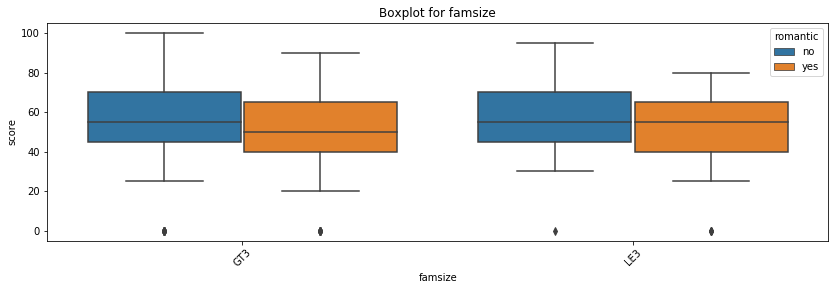

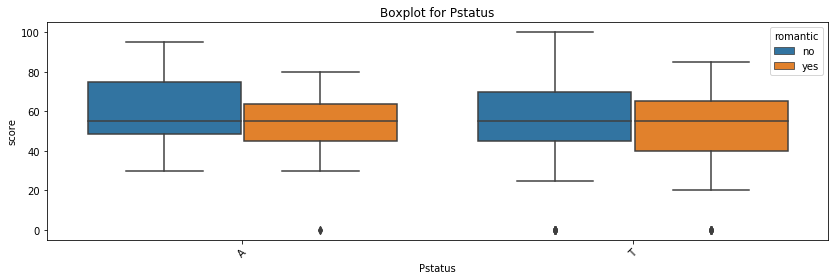

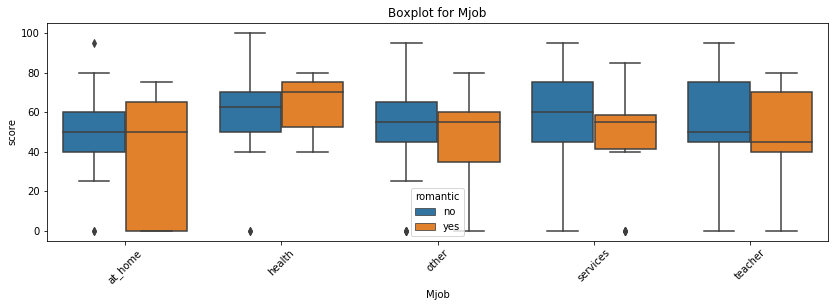

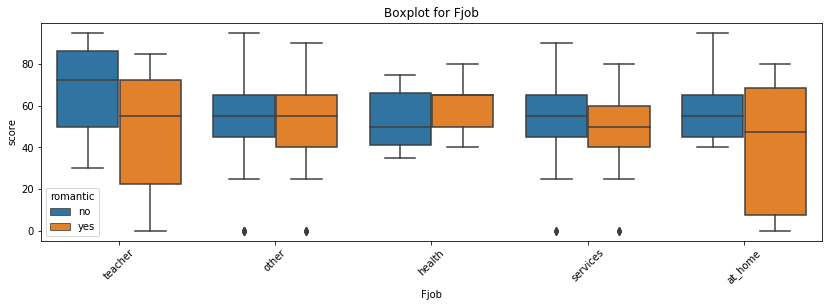

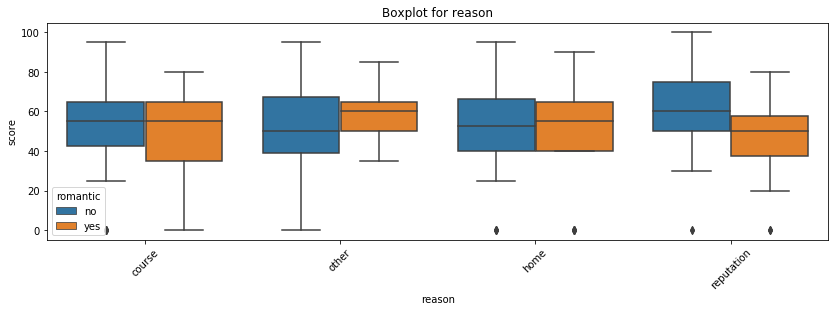

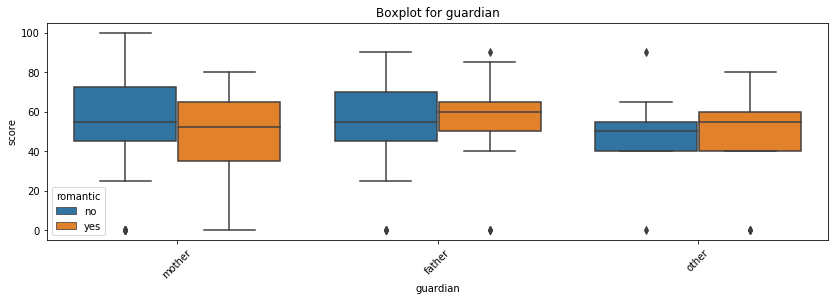

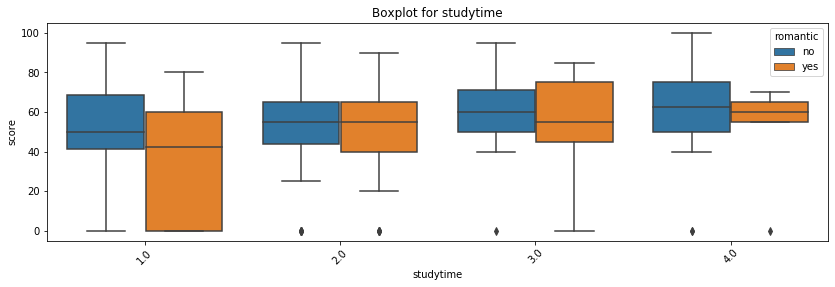

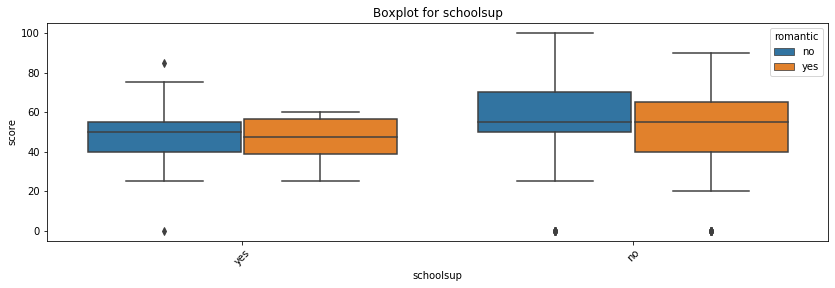

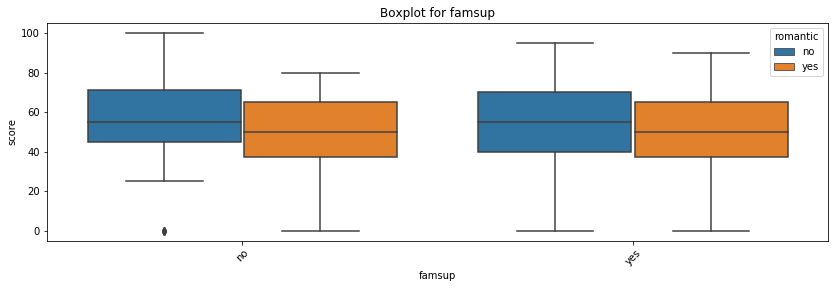

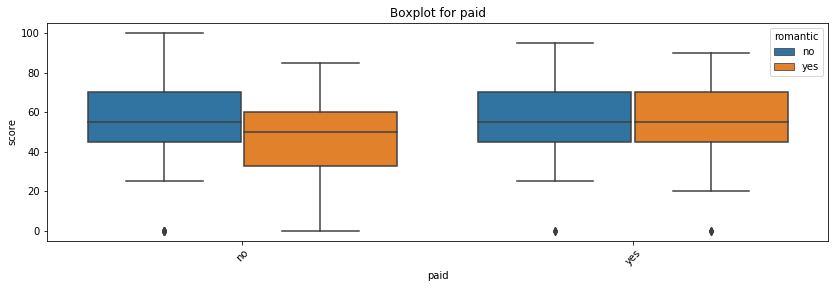

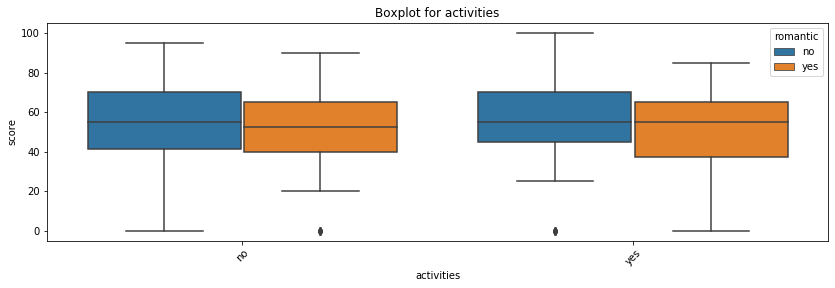

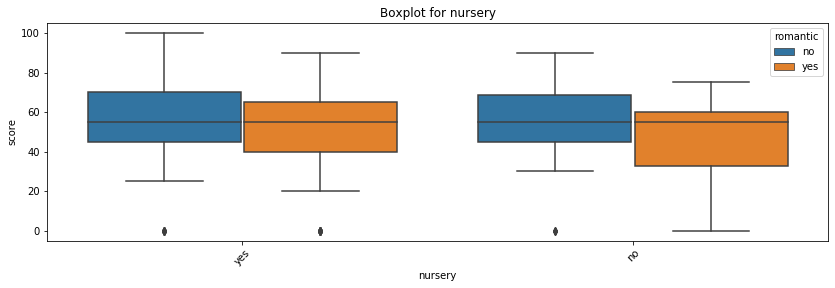

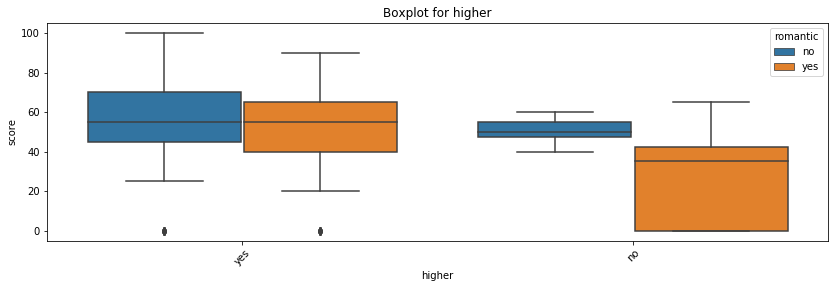

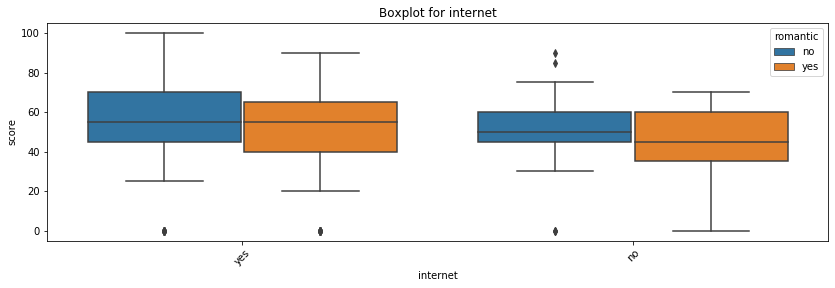

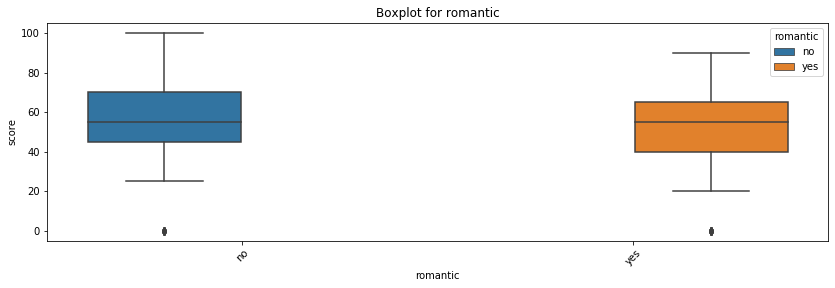

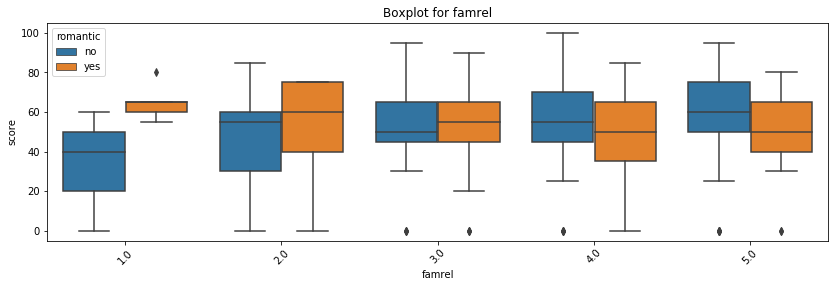

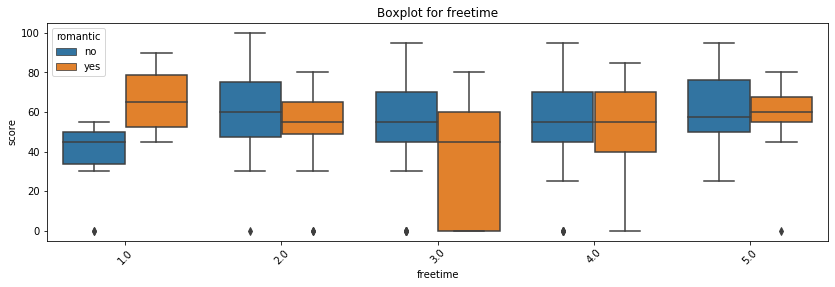

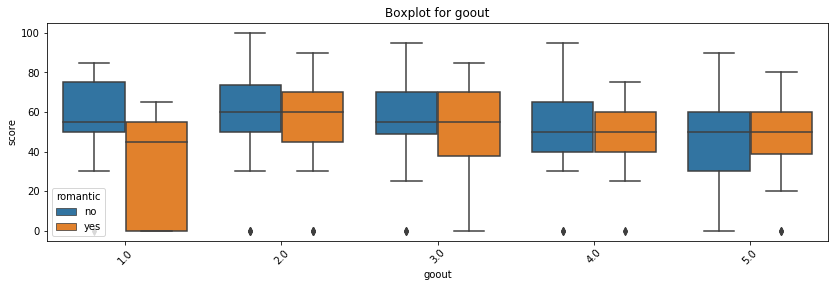

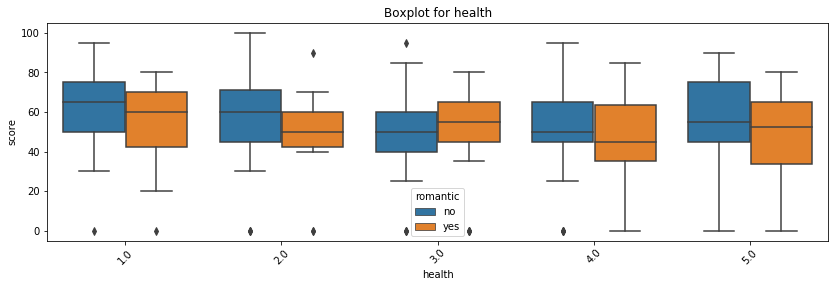

In [29]:
#Проанализируем номинативные переменные и устраним те, которые не влияют на предсказываемую величину
# перейдем к графическому анализу номиативных переменных с использованием boxplot
# опишем функцию отображения в качестве анализа возможной корреляции включим зависимость 
#графики от значений других строк дата фрейма 
def get_boxplot(column):
    fig, ax = plt.subplots(figsize = (14, 4))
    sns.boxplot(x=column, y='score', 
                data=stud_math.loc[stud_math.loc[:, column].isin(stud_math.loc[:, column])],hue ='romantic',
               ax=ax)
    plt.xticks(rotation=45)
    ax.set_title('Boxplot for ' + column)
    plt.show()
#отобразим данные
for col in ['school','Medu','Fedu','sex', 'traveltime','address','famsize','Pstatus','Mjob','Fjob','reason', 'guardian', 'studytime','schoolsup','famsup','paid','activities','nursery','higher','internet','romantic','famrel','freetime','goout','health']:
    get_boxplot(col)

#визуальный анализ позволяет нам сделать вывод о возможной корреляции номинативных переменных со score 
#подробные выводы предосатвлены отдельным файлом 

In [19]:
#попробуем определить статистически значимые перменные с помощью теста Стьюдента
#опишем функцию для проверки нулевой гипотезы
def get_stat_dif(column):
    c = stud_math.loc[:, column].value_counts().index[:10]
    combinations_all = list(combinations(c, 2))
    for comb in combinations_all:
        if ttest_ind(stud_math.loc[stud_math.loc[:, column] == comb[0], 'score'], 
                        stud_math.loc[stud_math.loc[:, column] == comb[1], 'score']).pvalue \
            <= 0.05/len(combinations_all): # Учли поправку Бонферони
            print('Найдены статистически значимые различия для колонки', column)
            break

for col in ['school','Medu','Fedu','sex', 'traveltime','address','famsize','Pstatus','Mjob','Fjob','reason', 'guardian', 'studytime','schoolsup','famsup','paid','activities','nursery','higher','internet','romantic','famrel','freetime','goout','health']:
    get_stat_dif(col) 



Найдены статистически значимые различия для колонки Medu
Найдены статистически значимые различия для колонки address
Найдены статистически значимые различия для колонки Mjob
Найдены статистически значимые различия для колонки higher
Найдены статистически значимые различия для колонки romantic
